In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
%matplotlib inline


In [18]:
DATASET = "CIFAR10"
EPOCHS = 10
BATCH_SIZE = 64
LATENT_DIM = 100
MESSAGE_WIDTH = 40
GENERATOR_NUM_FILTERS = 256
DISCRIMINATOR_NUM_FILTERS = 128
DECODER_NUM_FILTERS = 64

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified


In [20]:
class Generator(nn.Module):
    def __init__(self, latent_dim, msg_width, img_shape, base_filters=128):
        super().__init__()
        self.init_size = img_shape[1] // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + msg_width, base_filters * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(base_filters),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_filters, base_filters, 3, 1, 1),
            nn.BatchNorm2d(base_filters, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_filters, base_filters // 2, 3, 1, 1),
            nn.BatchNorm2d(base_filters // 2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_filters // 2, img_shape[0], 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z, msg):
        x = torch.cat((z, msg), dim=1)
        out = self.l1(x)
        out = out.view(out.size(0), GENERATOR_NUM_FILTERS, self.init_size, self.init_size)
        return self.conv_blocks(out)


class Discriminator(nn.Module):
    def __init__(self, img_shape, base_filters=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], base_filters, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(base_filters, base_filters * 2, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(base_filters * 2, base_filters * 4, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )
        _ = torch.zeros(1, *img_shape)
        flat_dim = self.model(_).shape[1]
        self.fc = nn.Linear(flat_dim, 1)

    def forward(self, img):
        return self.fc(self.model(img))


class Decoder(nn.Module):
    def __init__(self, img_shape, msg_width):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (img_shape[1] // 4) * (img_shape[2] // 4), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, msg_width),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [21]:
generator = Generator(LATENT_DIM, MESSAGE_WIDTH, (3, 32, 32), GENERATOR_NUM_FILTERS).to(device)
discriminator = Discriminator((3, 32, 32), DISCRIMINATOR_NUM_FILTERS).to(device)
decoder = Decoder((3, 32, 32), MESSAGE_WIDTH).to(device)

decoder_loss = nn.BCELoss()
gen_optim = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
dec_opt = optim.Adam(decoder.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [22]:
def train():
    for epoch in range(EPOCHS):
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            # --- Train Discriminator ---
            disc_optim.zero_grad()

            z = torch.randn(imgs.size(0), LATENT_DIM, device=device)
            msgs = torch.randint(0, 2, (imgs.size(0), MESSAGE_WIDTH), device=device, dtype=torch.float)
            fake_imgs = generator(z, msgs).detach()

            real_pred = discriminator(imgs)
            fake_pred = discriminator(fake_imgs)

            real_loss = torch.mean(F.relu(1.0 - real_pred))
            fake_loss = torch.mean(F.relu(1.0 + fake_pred))
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            disc_optim.step()

            # --- Train Generator + Decoder ---
            gen_optim.zero_grad()
            dec_opt.zero_grad()

            z = torch.randn(imgs.size(0), LATENT_DIM, device=device)
            msgs = torch.randint(0, 2, (imgs.size(0), MESSAGE_WIDTH), device=device, dtype=torch.float)
            gen_imgs = generator(z, msgs)
            validity = discriminator(gen_imgs)
            decoded = decoder(gen_imgs)

            gen_adv_loss = -torch.mean(validity)
            gen_aux_loss = decoder_loss(decoded, msgs)
            gen_loss = 0.5 * (gen_adv_loss + gen_aux_loss)

            gen_loss.backward()
            gen_optim.step()
            dec_opt.step()

            # --- Metrics ---
            pred_bits = (decoded > 0.5).float()
            bitwise_acc = (pred_bits == msgs).float().mean().item()
            full_recovery = ((pred_bits == msgs).all(dim=1).float().mean().item())

            if (i + 1) % 100 == 0:
                print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {disc_loss.item():.3f}] [G loss: {gen_loss.item():.3f}] "
                      f"(Adv: {gen_adv_loss.item():.3f}, Dec: {gen_aux_loss.item():.3f}) "
                      f"[Bit acc: {bitwise_acc:.3f}] [Full rec: {full_recovery:.3f}]")


        with torch.no_grad():
            z = torch.randn(25, LATENT_DIM, device=device)
            msg = torch.randint(0, 2, (25, MESSAGE_WIDTH), device=device, dtype=torch.float)
            samples = generator(z, msg).cpu()
            samples = (samples + 1) / 2  # [-1,1] -> [0,1]
            grid = np.transpose(samples, (0, 2, 3, 1))

        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for j, ax in enumerate(axes.flatten()):
            ax.imshow(grid[j])
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    torch.save(generator.state_dict(), "generator.pth")
    torch.save(decoder.state_dict(), "decoder.pth")

In [23]:
def show_samples():
    with torch.no_grad():
        z = torch.randn(25, LATENT_DIM, device=device)
        msg = torch.randint(0, 2, (25, MESSAGE_WIDTH), device=device, dtype=torch.float)
        samples = generator(z, msg).cpu()
        grid = np.transpose((samples + 1) / 2, (0, 2, 3, 1))

    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(grid[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


[Epoch 0/10] [Batch 99/782] [D loss: 1.760] [G loss: 0.978] (Adv: 1.263, Dec: 0.693) [Bit acc: 0.506] [Full rec: 0.000]
[Epoch 0/10] [Batch 199/782] [D loss: 2.097] [G loss: 0.885] (Adv: 1.078, Dec: 0.693) [Bit acc: 0.514] [Full rec: 0.000]
[Epoch 0/10] [Batch 299/782] [D loss: 1.783] [G loss: 0.531] (Adv: 0.378, Dec: 0.684) [Bit acc: 0.557] [Full rec: 0.000]
[Epoch 0/10] [Batch 399/782] [D loss: 2.247] [G loss: 0.230] (Adv: -0.213, Dec: 0.673) [Bit acc: 0.581] [Full rec: 0.000]
[Epoch 0/10] [Batch 499/782] [D loss: 1.850] [G loss: 0.303] (Adv: 0.052, Dec: 0.553) [Bit acc: 0.706] [Full rec: 0.000]
[Epoch 0/10] [Batch 599/782] [D loss: 1.734] [G loss: 0.413] (Adv: 0.603, Dec: 0.223) [Bit acc: 0.919] [Full rec: 0.078]
[Epoch 0/10] [Batch 699/782] [D loss: 2.068] [G loss: 0.343] (Adv: 0.638, Dec: 0.047) [Bit acc: 0.987] [Full rec: 0.609]


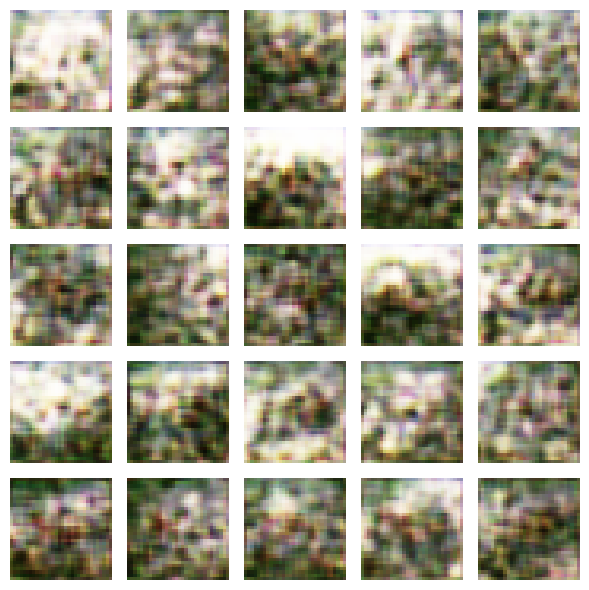

[Epoch 1/10] [Batch 99/782] [D loss: 1.848] [G loss: 0.289] (Adv: 0.528, Dec: 0.050) [Bit acc: 0.984] [Full rec: 0.562]
[Epoch 1/10] [Batch 199/782] [D loss: 1.845] [G loss: 0.298] (Adv: 0.576, Dec: 0.021) [Bit acc: 0.995] [Full rec: 0.828]
[Epoch 1/10] [Batch 299/782] [D loss: 1.936] [G loss: 0.447] (Adv: 0.832, Dec: 0.062) [Bit acc: 0.979] [Full rec: 0.688]
[Epoch 1/10] [Batch 399/782] [D loss: 1.998] [G loss: 0.004] (Adv: -0.029, Dec: 0.036) [Bit acc: 0.989] [Full rec: 0.609]
[Epoch 1/10] [Batch 499/782] [D loss: 2.077] [G loss: 0.081] (Adv: 0.139, Dec: 0.022) [Bit acc: 0.993] [Full rec: 0.766]
[Epoch 1/10] [Batch 599/782] [D loss: 2.079] [G loss: 0.105] (Adv: 0.186, Dec: 0.024) [Bit acc: 0.994] [Full rec: 0.828]
[Epoch 1/10] [Batch 699/782] [D loss: 1.699] [G loss: 0.398] (Adv: 0.738, Dec: 0.059) [Bit acc: 0.980] [Full rec: 0.562]


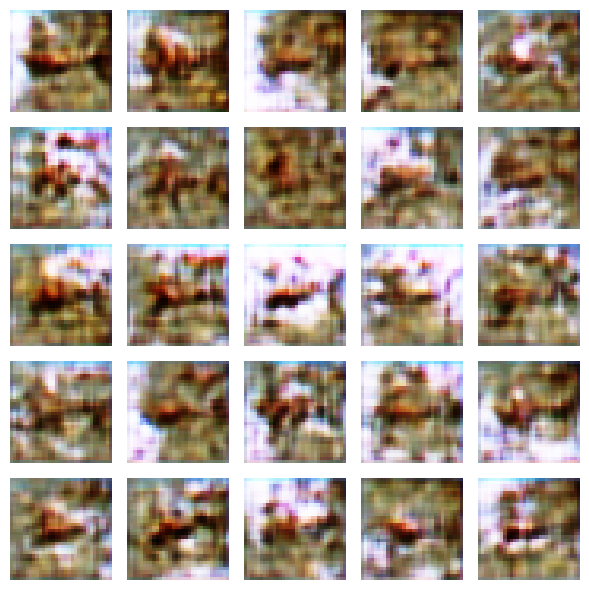

[Epoch 2/10] [Batch 99/782] [D loss: 2.320] [G loss: 0.768] (Adv: 1.473, Dec: 0.064) [Bit acc: 0.976] [Full rec: 0.469]
[Epoch 2/10] [Batch 199/782] [D loss: 1.749] [G loss: 0.641] (Adv: 1.225, Dec: 0.058) [Bit acc: 0.983] [Full rec: 0.547]
[Epoch 2/10] [Batch 299/782] [D loss: 1.089] [G loss: 0.470] (Adv: 0.918, Dec: 0.022) [Bit acc: 0.992] [Full rec: 0.734]
[Epoch 2/10] [Batch 399/782] [D loss: 1.563] [G loss: 0.506] (Adv: 0.967, Dec: 0.044) [Bit acc: 0.984] [Full rec: 0.609]
[Epoch 2/10] [Batch 499/782] [D loss: 1.711] [G loss: 0.395] (Adv: 0.706, Dec: 0.083) [Bit acc: 0.970] [Full rec: 0.375]
[Epoch 2/10] [Batch 599/782] [D loss: 1.691] [G loss: 0.196] (Adv: 0.378, Dec: 0.014) [Bit acc: 0.995] [Full rec: 0.844]
[Epoch 2/10] [Batch 699/782] [D loss: 0.803] [G loss: 0.651] (Adv: 1.257, Dec: 0.046) [Bit acc: 0.985] [Full rec: 0.578]


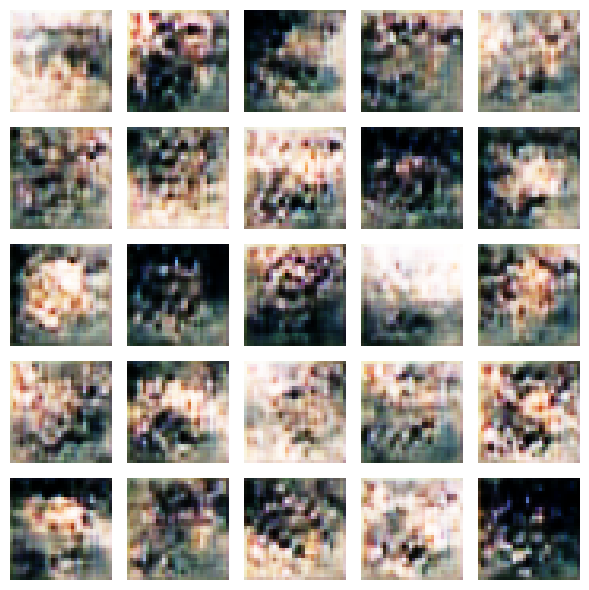

[Epoch 3/10] [Batch 99/782] [D loss: 2.854] [G loss: 0.571] (Adv: 1.042, Dec: 0.100) [Bit acc: 0.965] [Full rec: 0.281]
[Epoch 3/10] [Batch 199/782] [D loss: 2.001] [G loss: 0.342] (Adv: 0.627, Dec: 0.058) [Bit acc: 0.977] [Full rec: 0.406]
[Epoch 3/10] [Batch 299/782] [D loss: 1.466] [G loss: 0.460] (Adv: 0.852, Dec: 0.068) [Bit acc: 0.979] [Full rec: 0.438]
[Epoch 3/10] [Batch 399/782] [D loss: 1.964] [G loss: 0.360] (Adv: 0.554, Dec: 0.165) [Bit acc: 0.941] [Full rec: 0.156]
[Epoch 3/10] [Batch 499/782] [D loss: 1.434] [G loss: 0.488] (Adv: 0.921, Dec: 0.055) [Bit acc: 0.982] [Full rec: 0.531]
[Epoch 3/10] [Batch 599/782] [D loss: 1.853] [G loss: 0.290] (Adv: 0.511, Dec: 0.069) [Bit acc: 0.976] [Full rec: 0.375]
[Epoch 3/10] [Batch 699/782] [D loss: 1.428] [G loss: 0.677] (Adv: 1.282, Dec: 0.071) [Bit acc: 0.975] [Full rec: 0.391]


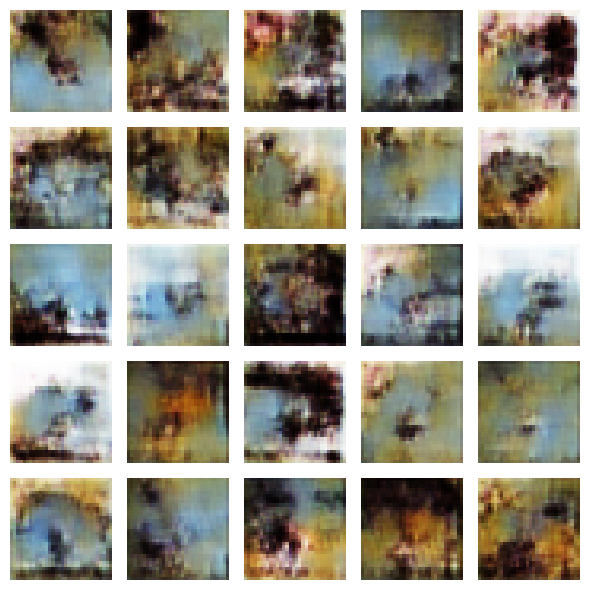

[Epoch 4/10] [Batch 99/782] [D loss: 1.717] [G loss: 0.495] (Adv: 0.919, Dec: 0.070) [Bit acc: 0.977] [Full rec: 0.375]
[Epoch 4/10] [Batch 199/782] [D loss: 1.010] [G loss: 0.531] (Adv: 0.996, Dec: 0.066) [Bit acc: 0.977] [Full rec: 0.469]
[Epoch 4/10] [Batch 299/782] [D loss: 1.495] [G loss: 0.397] (Adv: 0.720, Dec: 0.073) [Bit acc: 0.971] [Full rec: 0.391]
[Epoch 4/10] [Batch 399/782] [D loss: 1.477] [G loss: 0.601] (Adv: 1.129, Dec: 0.074) [Bit acc: 0.970] [Full rec: 0.375]
[Epoch 4/10] [Batch 499/782] [D loss: 1.298] [G loss: 0.581] (Adv: 1.093, Dec: 0.069) [Bit acc: 0.975] [Full rec: 0.359]
[Epoch 4/10] [Batch 599/782] [D loss: 1.068] [G loss: 0.594] (Adv: 1.156, Dec: 0.032) [Bit acc: 0.989] [Full rec: 0.703]
[Epoch 4/10] [Batch 699/782] [D loss: 1.358] [G loss: 0.286] (Adv: 0.522, Dec: 0.051) [Bit acc: 0.983] [Full rec: 0.594]


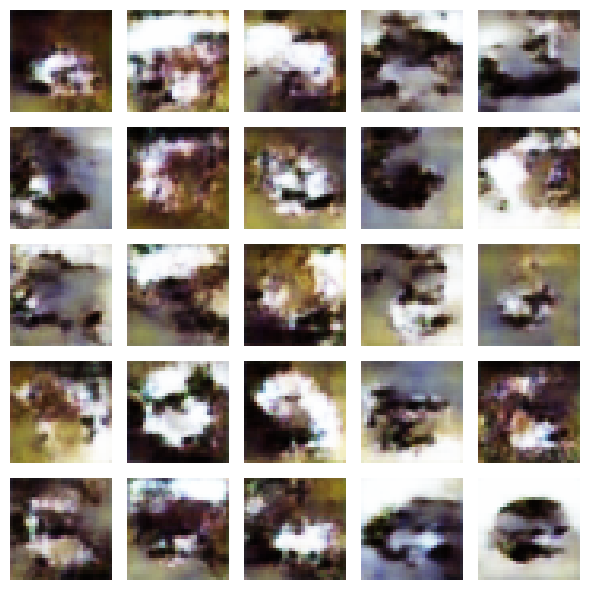

[Epoch 5/10] [Batch 99/782] [D loss: 1.527] [G loss: 0.379] (Adv: 0.711, Dec: 0.048) [Bit acc: 0.984] [Full rec: 0.609]
[Epoch 5/10] [Batch 199/782] [D loss: 1.563] [G loss: 0.522] (Adv: 0.986, Dec: 0.057) [Bit acc: 0.978] [Full rec: 0.469]
[Epoch 5/10] [Batch 299/782] [D loss: 1.775] [G loss: 0.514] (Adv: 0.992, Dec: 0.036) [Bit acc: 0.987] [Full rec: 0.594]
[Epoch 5/10] [Batch 399/782] [D loss: 1.718] [G loss: 0.531] (Adv: 0.990, Dec: 0.072) [Bit acc: 0.972] [Full rec: 0.406]
[Epoch 5/10] [Batch 499/782] [D loss: 1.394] [G loss: 0.377] (Adv: 0.715, Dec: 0.040) [Bit acc: 0.989] [Full rec: 0.641]
[Epoch 5/10] [Batch 599/782] [D loss: 1.763] [G loss: 0.321] (Adv: 0.603, Dec: 0.038) [Bit acc: 0.986] [Full rec: 0.594]
[Epoch 5/10] [Batch 699/782] [D loss: 1.455] [G loss: 0.518] (Adv: 1.011, Dec: 0.025) [Bit acc: 0.994] [Full rec: 0.781]


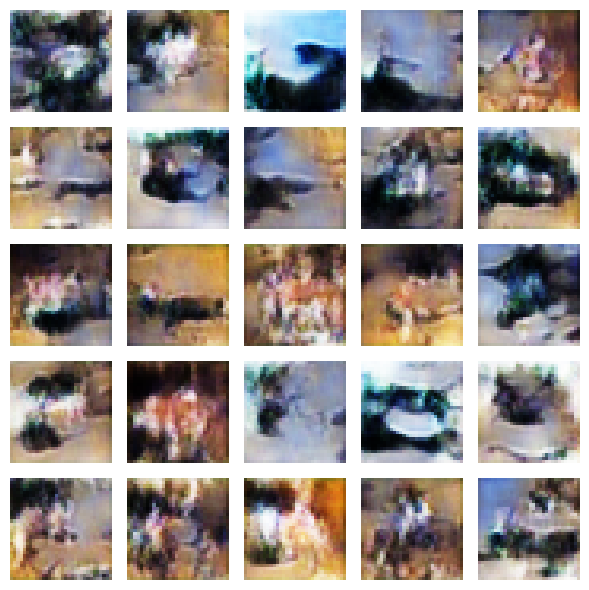

[Epoch 6/10] [Batch 99/782] [D loss: 1.531] [G loss: 0.393] (Adv: 0.734, Dec: 0.052) [Bit acc: 0.982] [Full rec: 0.625]
[Epoch 6/10] [Batch 199/782] [D loss: 1.871] [G loss: 0.313] (Adv: 0.595, Dec: 0.031) [Bit acc: 0.987] [Full rec: 0.594]
[Epoch 6/10] [Batch 299/782] [D loss: 1.686] [G loss: 0.228] (Adv: 0.408, Dec: 0.048) [Bit acc: 0.987] [Full rec: 0.688]
[Epoch 6/10] [Batch 399/782] [D loss: 1.341] [G loss: 0.366] (Adv: 0.701, Dec: 0.030) [Bit acc: 0.990] [Full rec: 0.766]
[Epoch 6/10] [Batch 499/782] [D loss: 2.104] [G loss: 0.397] (Adv: 0.770, Dec: 0.024) [Bit acc: 0.993] [Full rec: 0.766]
[Epoch 6/10] [Batch 599/782] [D loss: 1.715] [G loss: 0.489] (Adv: 0.959, Dec: 0.020) [Bit acc: 0.993] [Full rec: 0.781]
[Epoch 6/10] [Batch 699/782] [D loss: 1.481] [G loss: 0.379] (Adv: 0.714, Dec: 0.043) [Bit acc: 0.982] [Full rec: 0.469]


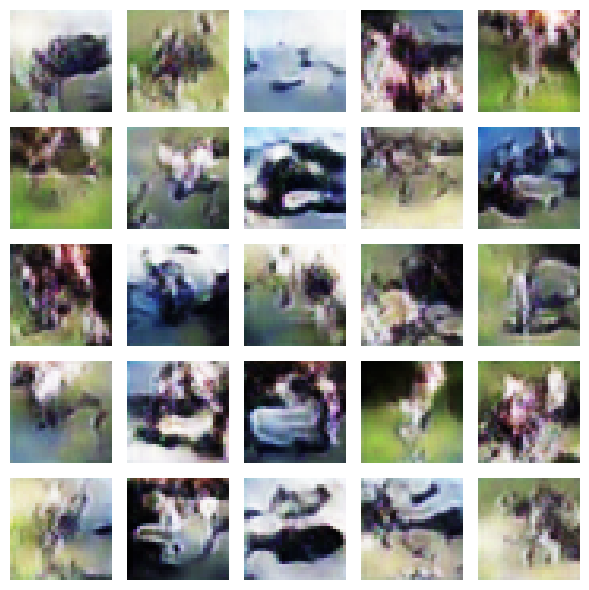

[Epoch 7/10] [Batch 99/782] [D loss: 1.593] [G loss: 0.471] (Adv: 0.805, Dec: 0.136) [Bit acc: 0.948] [Full rec: 0.234]
[Epoch 7/10] [Batch 199/782] [D loss: 1.933] [G loss: 0.178] (Adv: 0.323, Dec: 0.034) [Bit acc: 0.991] [Full rec: 0.734]
[Epoch 7/10] [Batch 299/782] [D loss: 1.889] [G loss: 0.207] (Adv: 0.378, Dec: 0.036) [Bit acc: 0.986] [Full rec: 0.547]
[Epoch 7/10] [Batch 399/782] [D loss: 1.417] [G loss: 0.437] (Adv: 0.862, Dec: 0.013) [Bit acc: 0.995] [Full rec: 0.828]
[Epoch 7/10] [Batch 499/782] [D loss: 1.902] [G loss: 0.321] (Adv: 0.617, Dec: 0.026) [Bit acc: 0.991] [Full rec: 0.734]
[Epoch 7/10] [Batch 599/782] [D loss: 1.788] [G loss: 0.372] (Adv: 0.724, Dec: 0.020) [Bit acc: 0.994] [Full rec: 0.812]
[Epoch 7/10] [Batch 699/782] [D loss: 1.702] [G loss: 0.295] (Adv: 0.577, Dec: 0.014) [Bit acc: 0.997] [Full rec: 0.891]


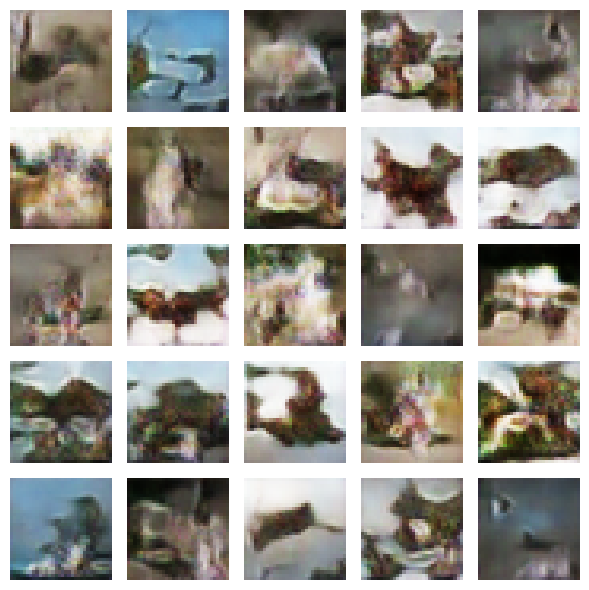

[Epoch 8/10] [Batch 99/782] [D loss: 1.950] [G loss: 0.196] (Adv: 0.370, Dec: 0.022) [Bit acc: 0.994] [Full rec: 0.844]
[Epoch 8/10] [Batch 199/782] [D loss: 1.556] [G loss: 0.406] (Adv: 0.796, Dec: 0.015) [Bit acc: 0.997] [Full rec: 0.906]
[Epoch 8/10] [Batch 299/782] [D loss: 1.881] [G loss: 0.437] (Adv: 0.860, Dec: 0.015) [Bit acc: 0.995] [Full rec: 0.875]
[Epoch 8/10] [Batch 399/782] [D loss: 1.770] [G loss: 0.228] (Adv: 0.446, Dec: 0.011) [Bit acc: 0.997] [Full rec: 0.891]
[Epoch 8/10] [Batch 499/782] [D loss: 1.720] [G loss: 0.331] (Adv: 0.643, Dec: 0.019) [Bit acc: 0.994] [Full rec: 0.844]
[Epoch 8/10] [Batch 599/782] [D loss: 1.657] [G loss: 0.389] (Adv: 0.749, Dec: 0.028) [Bit acc: 0.991] [Full rec: 0.812]
[Epoch 8/10] [Batch 699/782] [D loss: 2.064] [G loss: 0.237] (Adv: 0.456, Dec: 0.018) [Bit acc: 0.994] [Full rec: 0.844]


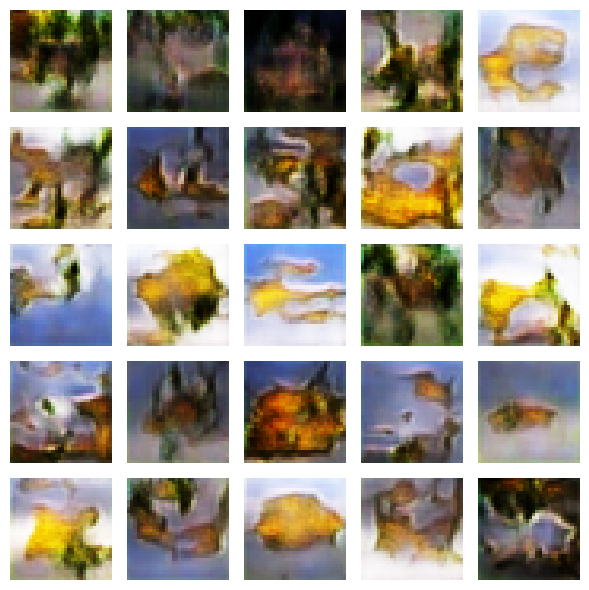

[Epoch 9/10] [Batch 99/782] [D loss: 1.513] [G loss: 0.265] (Adv: 0.514, Dec: 0.015) [Bit acc: 0.997] [Full rec: 0.891]
[Epoch 9/10] [Batch 199/782] [D loss: 1.792] [G loss: 0.341] (Adv: 0.663, Dec: 0.019) [Bit acc: 0.994] [Full rec: 0.797]
[Epoch 9/10] [Batch 299/782] [D loss: 1.710] [G loss: 0.227] (Adv: 0.442, Dec: 0.012) [Bit acc: 0.996] [Full rec: 0.859]
[Epoch 9/10] [Batch 399/782] [D loss: 1.476] [G loss: 0.267] (Adv: 0.511, Dec: 0.022) [Bit acc: 0.994] [Full rec: 0.828]
[Epoch 9/10] [Batch 499/782] [D loss: 1.639] [G loss: 0.229] (Adv: 0.451, Dec: 0.008) [Bit acc: 0.998] [Full rec: 0.953]
[Epoch 9/10] [Batch 599/782] [D loss: 1.394] [G loss: 0.272] (Adv: 0.535, Dec: 0.008) [Bit acc: 0.998] [Full rec: 0.922]
[Epoch 9/10] [Batch 699/782] [D loss: 1.562] [G loss: 0.325] (Adv: 0.629, Dec: 0.021) [Bit acc: 0.993] [Full rec: 0.812]


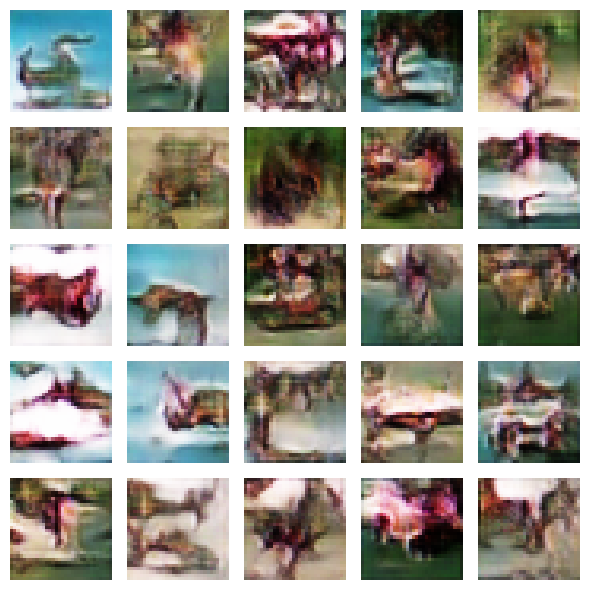

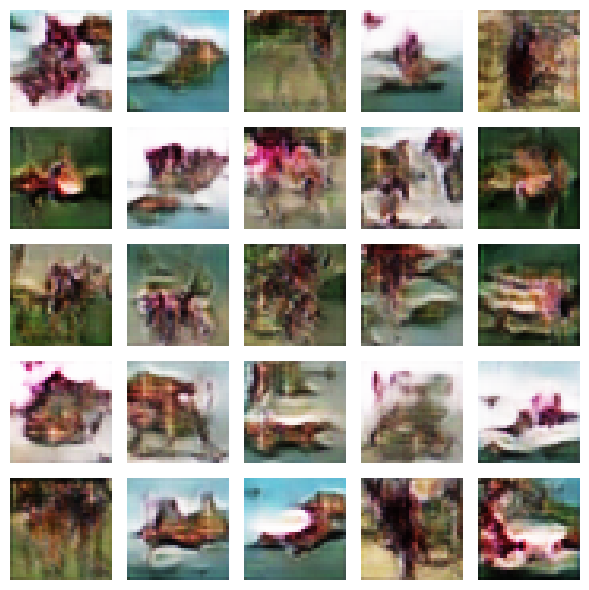

In [24]:
train()
show_samples()


✅ Saved image as 'generated_image.png'


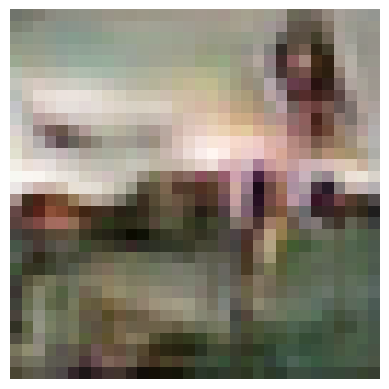

Original message:
ABCDE

Original message bits:
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0
 1 0 1]

Decoded message bits:
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0
 1 0 1]

Decoded ASCII message:
ABCDE


In [46]:
text_message = "ABCDE"

# Convert text to bits (ASCII)
binary_str = ''.join(format(ord(c), '08b') for c in text_message)
bits = [int(b) for b in binary_str]
msg = torch.tensor(bits, dtype=torch.float, device=device).unsqueeze(0)

generator.load_state_dict(torch.load("generator.pth", map_location=device))
decoder.load_state_dict(torch.load("decoder.pth", map_location=device))
generator.eval()
decoder.eval()

# Generate random latent vector and message
z = torch.randn(1, LATENT_DIM, device=device)

# Generate image and decode message
with torch.no_grad():
    gen_img = generator(z, msg).detach().cpu()
    decoded = decoder(gen_img.to(device))
    pred_bits = (decoded > 0.5).float()

save_image(gen_img, "generated_image.png", normalize=True)
print("Saved image as 'generated_image.png'")


# Display generated image inline
img = gen_img.squeeze(0).permute(1, 2, 0)  # CHW → HWC
img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]

plt.imshow(img)
plt.axis("off")
plt.show()

print("Original message:")
print(text_message)

print("\nOriginal message bits:")
print(msg.cpu().numpy().astype(int).flatten())

print("\nDecoded message bits:")
decoded_bits = pred_bits.cpu().numpy().astype(int).flatten()
print(decoded_bits)

# Decode bits -> ASCII
decoded_str = ''.join(str(b) for b in decoded_bits)
decoded_chars = [
    chr(int(decoded_str[i:i+8], 2))
    for i in range(0, len(decoded_str), 8)
    if len(decoded_str[i:i+8]) == 8
]
decoded_text = ''.join(decoded_chars)

print("\nDecoded ASCII message:")
print(decoded_text)



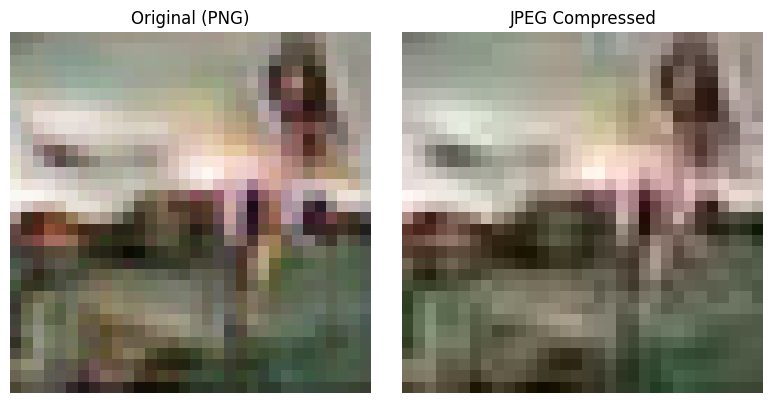

Decoded bits (JPEG):
[1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1
 1 0 0]

Decoded ASCII message (JPEG):
Ôü¡¼


In [50]:
# --- Test JPEG Compression  ---


# Load original image
original = Image.open("generated_image.png").convert("RGB")

# Apply JPEG compression in-memory
buffer = io.BytesIO()
original.save(buffer, format="JPEG", quality=50)  # adjust quality (10–90)
buffer.seek(0)
compressed = Image.open(buffer).convert("RGB")

# Display side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original)
axes[0].set_title("Original (PNG)")
axes[0].axis("off")

axes[1].imshow(compressed)
axes[1].set_title("JPEG Compressed")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Convert compressed image to tensor for decoder
compressed_tensor = (
    torch.tensor(np.array(compressed))
    .permute(2, 0, 1)  # HWC -> CHW
    .unsqueeze(0)      # add batch dim
    .float() / 255.0
).to(device)

# Run decoder
decoder.eval()
with torch.no_grad():
    decoded_jpg = decoder(compressed_tensor)
    pred_bits_jpg = (decoded_jpg > 0.5).float().cpu().numpy().astype(int).flatten()

print("Decoded bits (JPEG):")
print(pred_bits_jpg)

# Bits → ASCII
decoded_str = ''.join(str(b) for b in pred_bits_jpg)
decoded_chars = [
    chr(int(decoded_str[i:i+8], 2))
    for i in range(0, len(decoded_str), 8)
    if len(decoded_str[i:i+8]) == 8
]
decoded_text = ''.join(decoded_chars)

print("\nDecoded ASCII message (JPEG):")
print(decoded_text)
